In [77]:
import pandas as pd
import numpy as np

In [115]:
def draw_reg(source_cluster, variable_of_interest):
    total_regressor = pd.read_csv(f"../../../regressor/gangnam_total_{variable_of_interest}_regressor.csv")
    for group in ["total", "sad"]:
        cluster_table_file = f"/mnt/NAS2-2/data/SAD_gangnam_seed_based_analysis/6mm/second_level_results/3/HADS_depression/{source_cluster}/gangnam_{group}_HADS_depression_regressor/{source_cluster}_cluster_table.csv"

        cluster_table = pd.read_csv(cluster_table_file)
        cluster_table["Cluster ID"] = cluster_table["Cluster ID"].astype(str)
        numeric_cluster = cluster_table[cluster_table["Cluster ID"].str.isnumeric()][["Cluster ID", "Center of Mass AAL Label", "Peak Stat"]]

        for index, row in numeric_cluster.iterrows():
            stat_value = row["Peak Stat"]
            stat_value_rounded = round(stat_value, 2)    
            aal_label = row["Center of Mass AAL Label"]
            connectivity_file = f"/mnt/NAS2-2/data/SAD_gangnam_seed_based_analysis/6mm/second_level_results/3/HADS_depression/{source_cluster}/gangnam_{group}_HADS_depression_regressor/cluster_masks/{source_cluster}_{aal_label}_{stat_value_rounded}.csv"
            connectivity = pd.read_csv(connectivity_file)
            merged_df = pd.merge(total_regressor, connectivity, on='Participant', how='left')
            # 중복된 _y 컬럼 제거
            merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_y')]
            # _x 접미사를 제거하여 컬럼 이름 정리
            merged_df.columns = merged_df.columns.str.replace('_x', '', regex=True)
            merged_df['Group'] = merged_df['Participant'].apply(lambda x: 'SAD' if x.startswith('s') else 'HC')
            plot_reg(merged_df, group, source_cluster, aal_label)

In [142]:
def plot_reg(merged_df, group, source_cluster, aal_label):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy import stats

    # 각 그룹별로 데이터를 분리
    group_hc = merged_df[merged_df['Group'] == 'HC']
    group_sad = merged_df[merged_df['Group'] == 'SAD']

    # HC 그룹 상관계수와 p-value 계산
    corr_hc, p_value_hc = stats.pearsonr(group_hc['HADS_depression'], group_hc['Significant Correlation'])

    # SAD 그룹 상관계수와 p-value 계산
    corr_sad, p_value_sad = stats.pearsonr(group_sad['HADS_depression'], group_sad['Significant Correlation'])

    # 전체 데이터를 위한 상관계수와 p-value 계산
    corr_total, p_value_total = stats.pearsonr(merged_df['HADS_depression'], merged_df['Significant Correlation'])

    # scatter plot과 회귀선 그리기 (legend 안으로 이동)
    sns.set(style="whitegrid")
    plot = sns.lmplot(x='HADS_depression', y='Significant Correlation', hue="Group", data=merged_df, robust=True,
                      legend_out=False, height=6, aspect=1.2)

    # 전체 데이터에 대한 회귀선 추가
    sns.regplot(x='HADS_depression', y='Significant Correlation', data=merged_df, scatter=False, ax=plot.axes[0, 0],
                color='green', label=f'Total (r = {corr_total:.2f}, p = {p_value_total:.4f})')

    # x, y 라벨 및 타이틀 설정
    plt.xlabel('HADS_depression')
    plt.ylabel('Connectivity (Pearson R)')
    plt.title(f'[{group}] {source_cluster} <-> {aal_label}', fontsize=16)

    # HC 그룹의 상관계수와 p-value를 플롯에 추가
    plt.text(0.60, 0.05, f'HC: r = {corr_hc:.2f}, p = {p_value_hc:.4f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='orange')

    # SAD 그룹의 상관계수와 p-value를 플롯에 추가
    plt.text(0.60, 0.10, f'SAD: r = {corr_sad:.2f}, p = {p_value_sad:.4f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='blue')

    # 전체 그룹의 상관계수와 p-value를 플롯에 추가
    plt.text(0.60, 0.15, f'Total: r = {corr_total:.2f}, p = {p_value_total:.4f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='green')

    # Group legend 위치를 그래프 안으로 이동
    plt.legend(loc='upper left', fontsize=12)

    # 그래프 출력 (dpi 300으로 설정)
    plt.savefig("plot.png", dpi=300)
    plt.show()

    # 그룹간 통계 테스트 (독립 샘플 t-검정)
    t_stat, p_value = stats.ttest_ind(group_hc['Significant Correlation'], group_sad['Significant Correlation'], equal_var=False)

    # t-검정 결과 출력
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

    # 그룹간 평균 계산
    mean_hc = group_hc['Significant Correlation'].mean()
    mean_sad = group_sad['Significant Correlation'].mean()

    # 그룹 간 비교 표시용 텍스트
    if mean_sad > mean_hc:
        comparison = "SAD > HC"
    else:
        comparison = "HC > SAD"

    # Violin plot과 박스플롯 그리기
    plt.figure(figsize=(6, 6))
    
    # Violin plot
    sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")

    # 박스플롯 추가
    sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")

    # 타이틀 설정
    plt.title(f'Significant Correlation by Group (HC vs SAD)')

    # 통계 결과 텍스트 표시
    plt.text(0.6, 0.05, f'T-statistic: {t_stat:.4f}\nP-value: {p_value:.4f}\n{comparison}', 
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, color='black')

    # 그래프 출력
    plt.show()


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


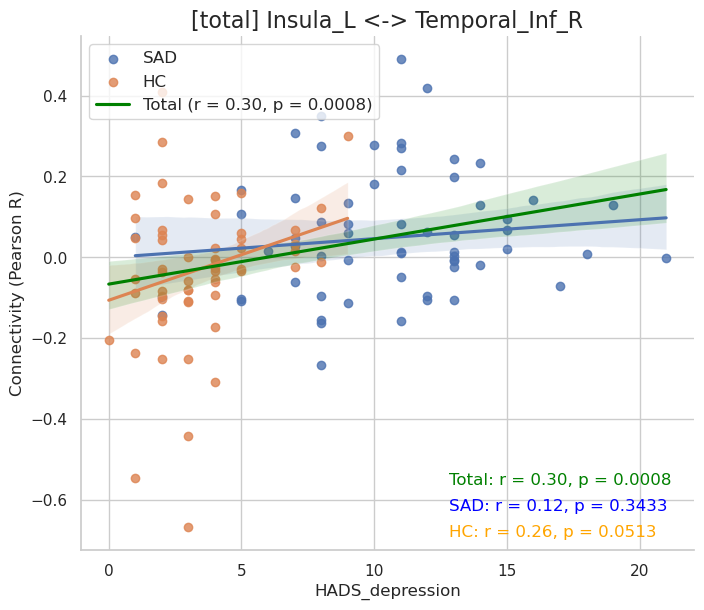

T-statistic: -3.0361, P-value: 0.0030


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


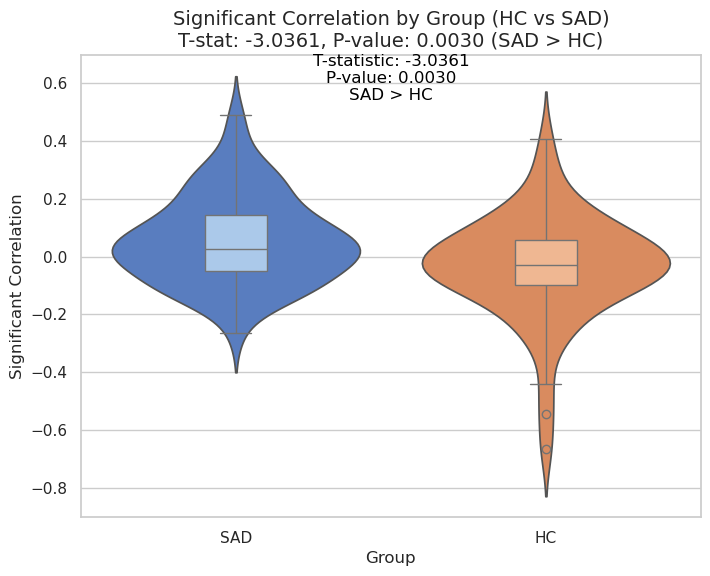

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


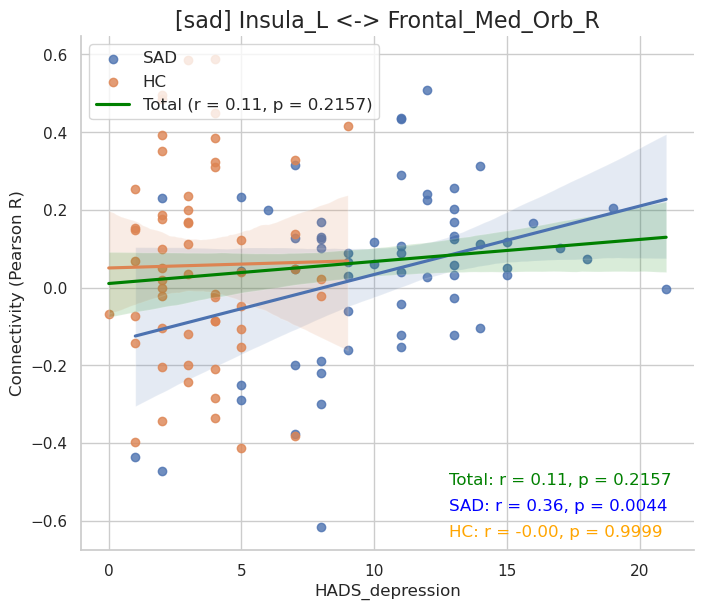

T-statistic: 0.4582, P-value: 0.6477


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


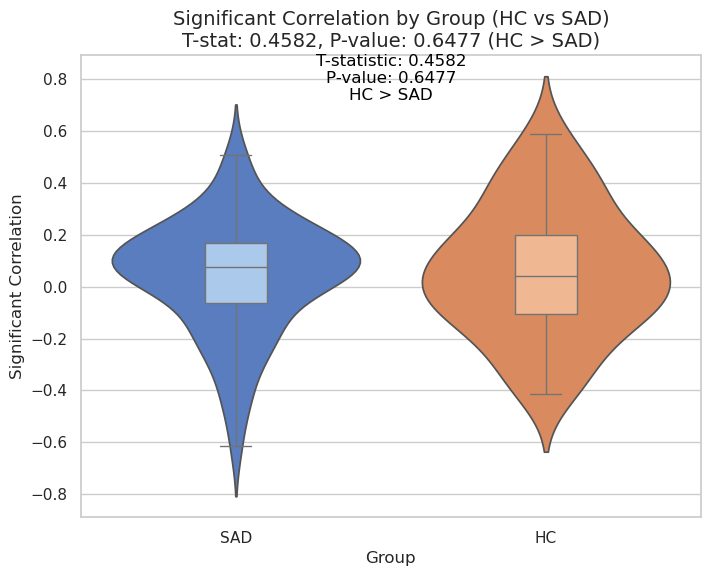

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


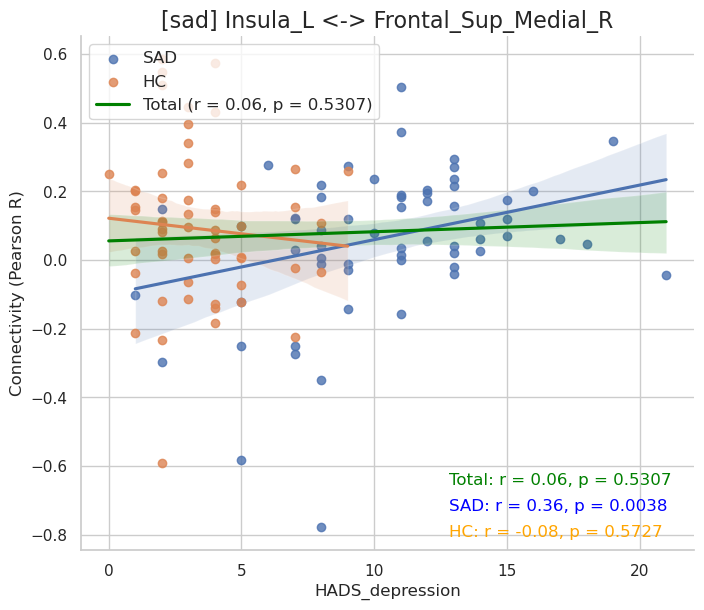

T-statistic: 1.2151, P-value: 0.2268


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


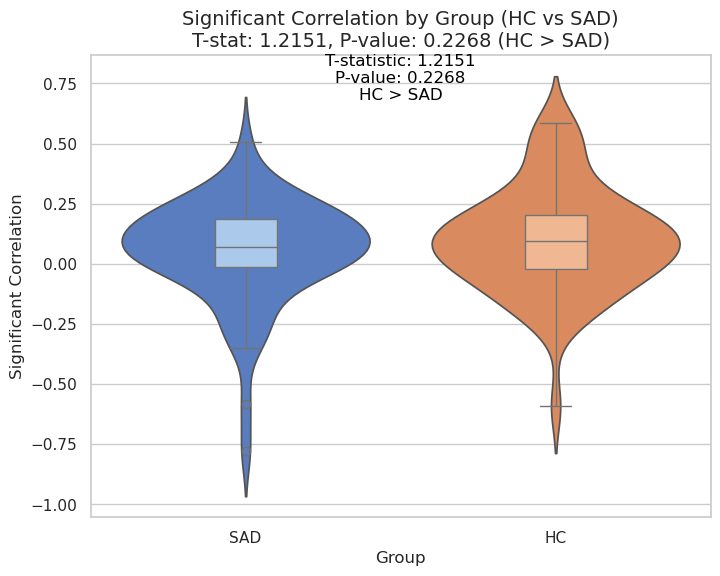

In [143]:
source_cluster = "Insula_L"
variable_of_interest = "HADS_depression"
draw_reg(source_cluster, variable_of_interest)

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


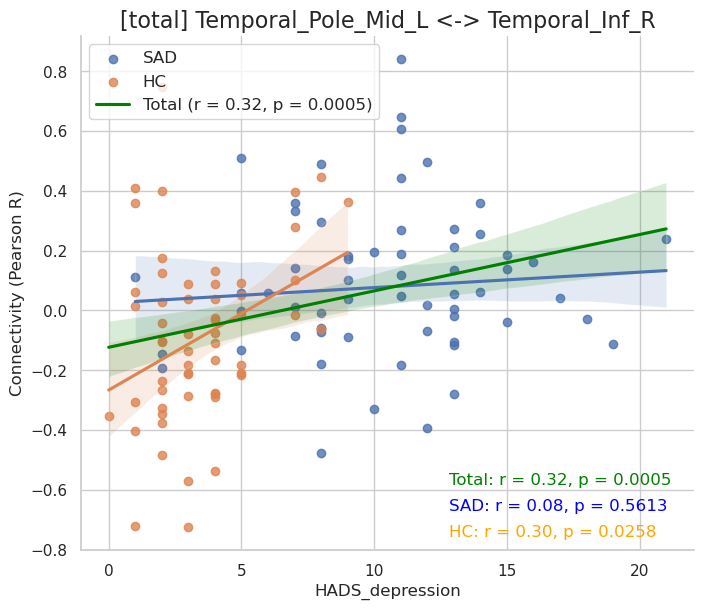

T-statistic: -3.4376, P-value: 0.0008


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


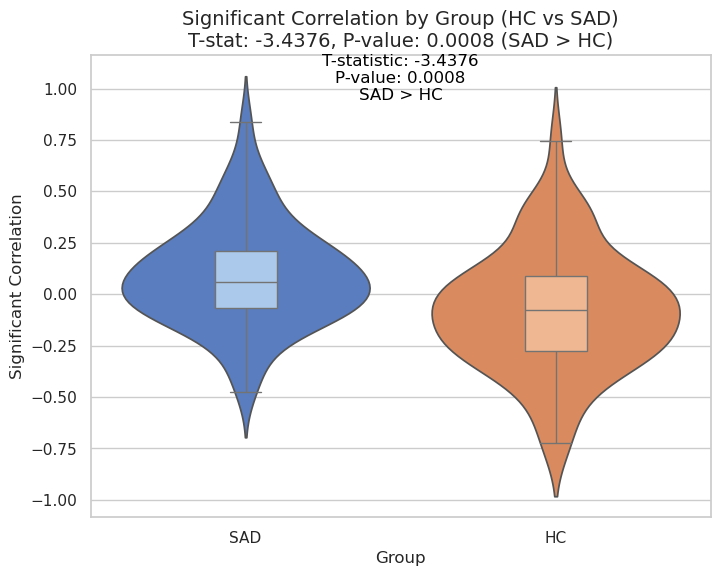

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


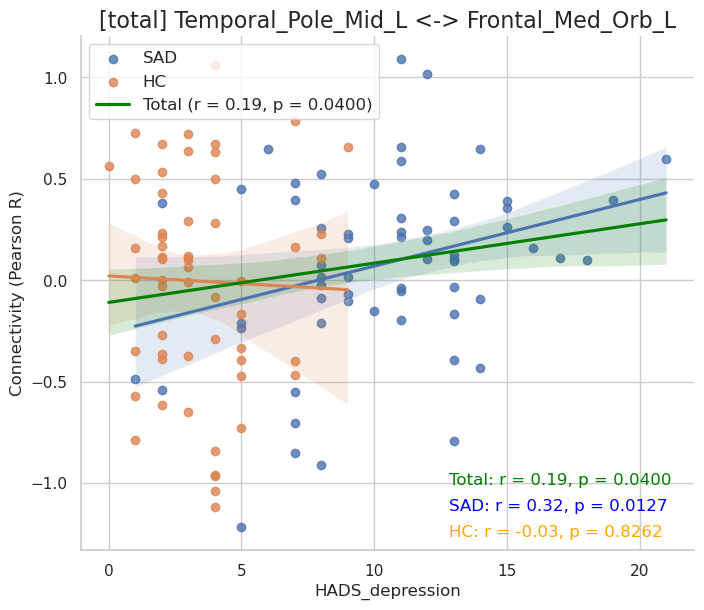

T-statistic: -1.0019, P-value: 0.3186


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


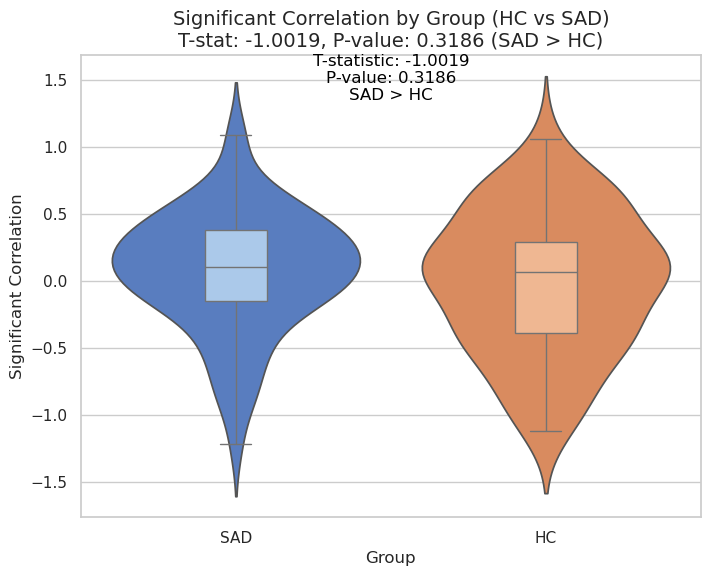

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


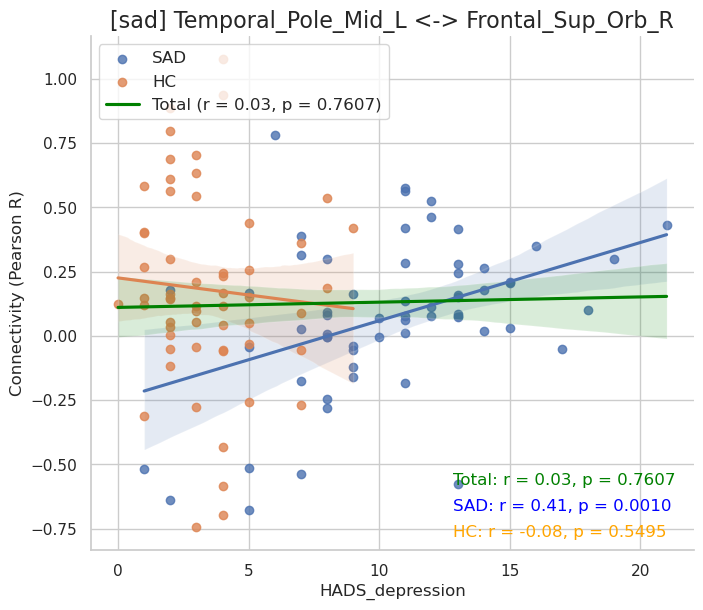

T-statistic: 1.6147, P-value: 0.1093


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


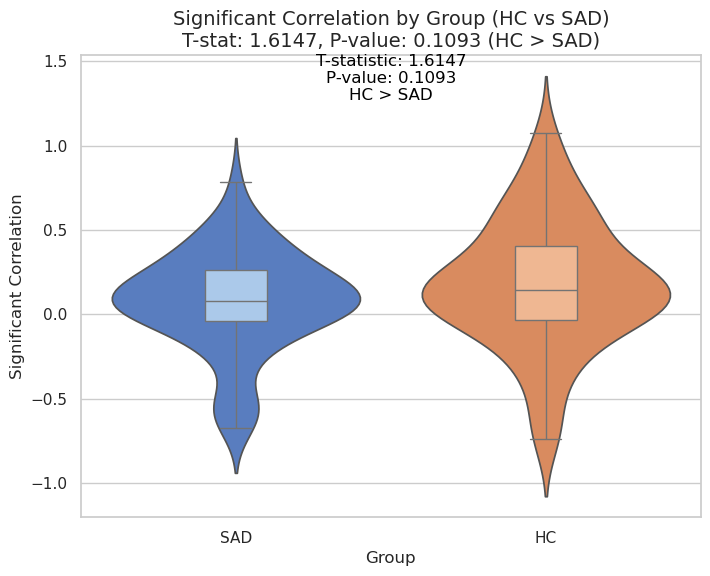

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


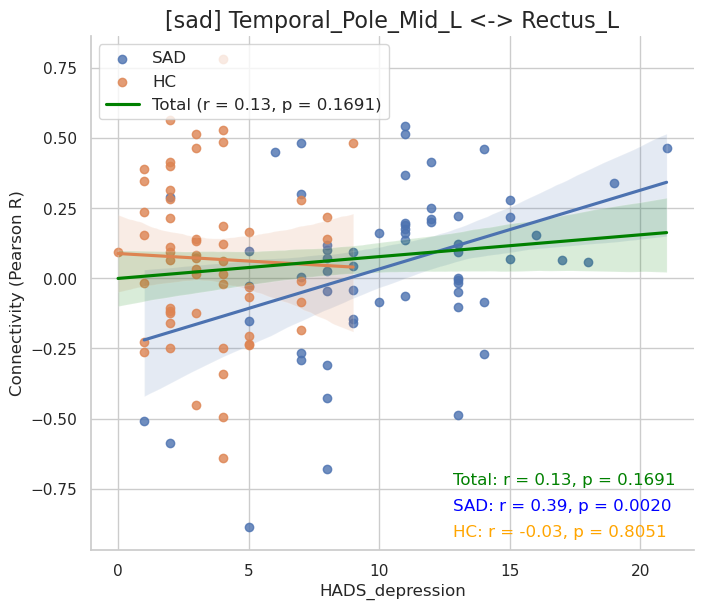

T-statistic: 0.5449, P-value: 0.5869


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


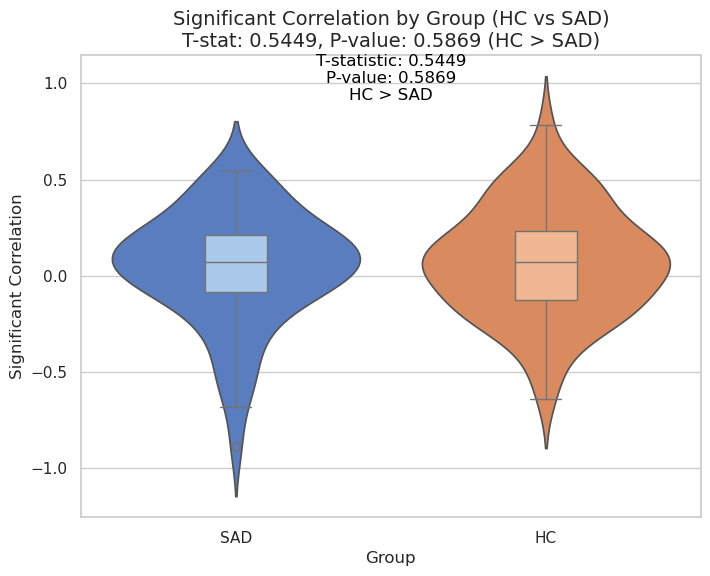

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


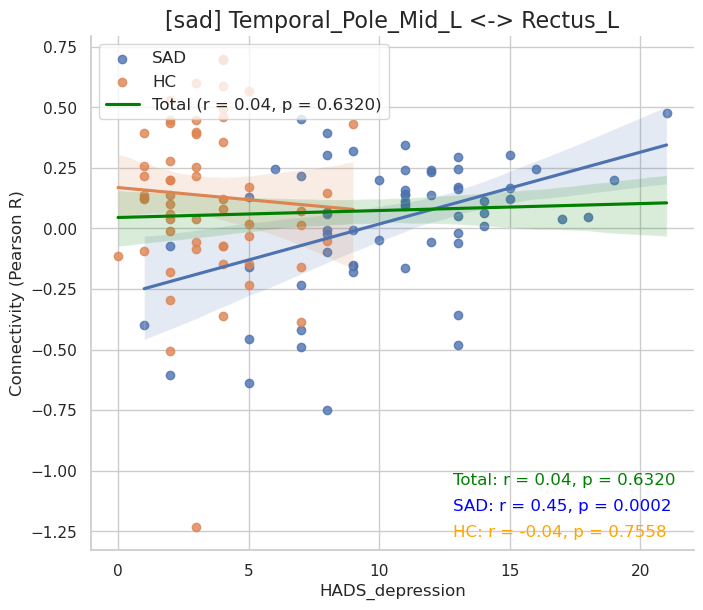

T-statistic: 1.7979, P-value: 0.0750


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


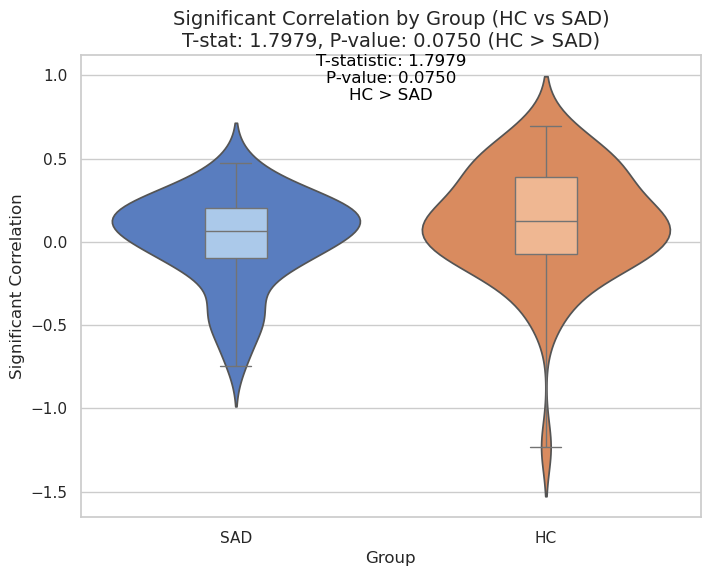

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


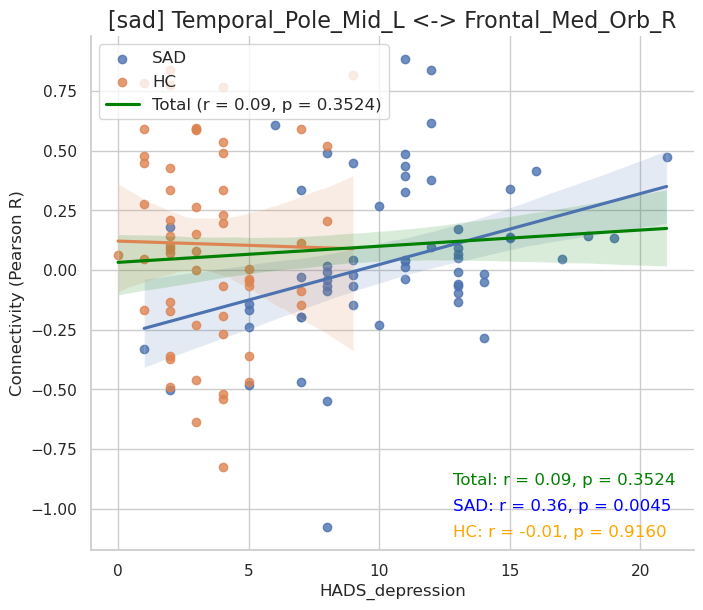

T-statistic: 0.7554, P-value: 0.4517


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


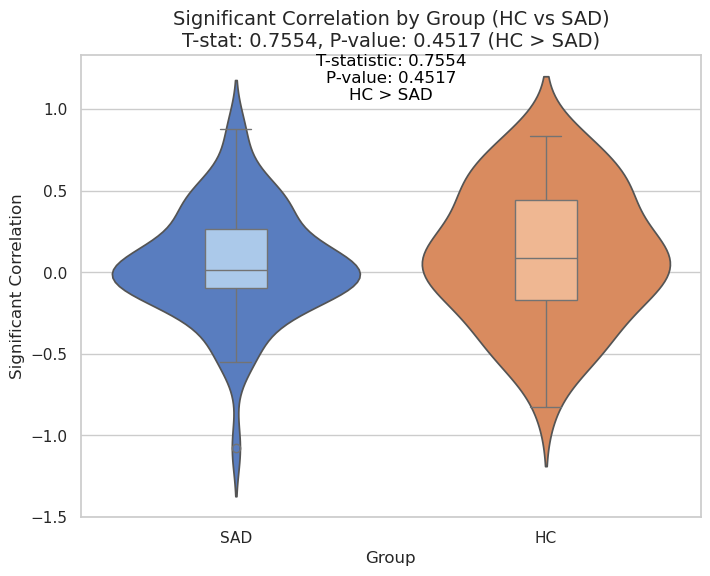

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


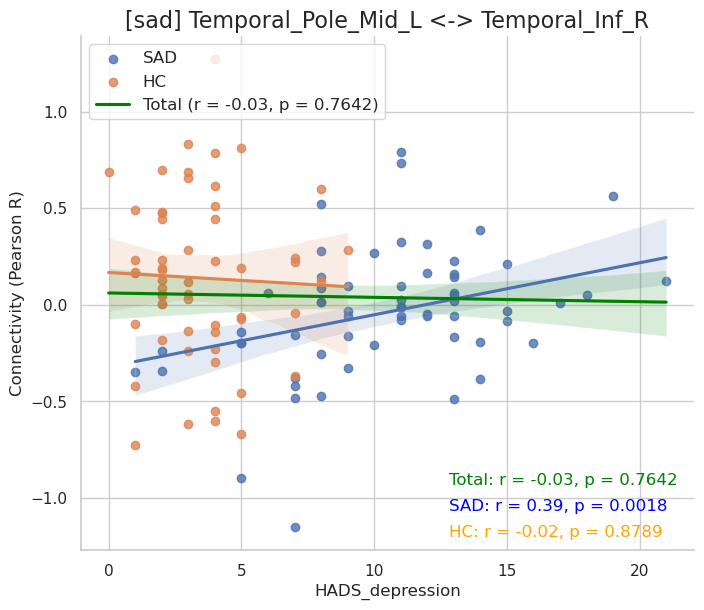

T-statistic: 2.5039, P-value: 0.0138


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


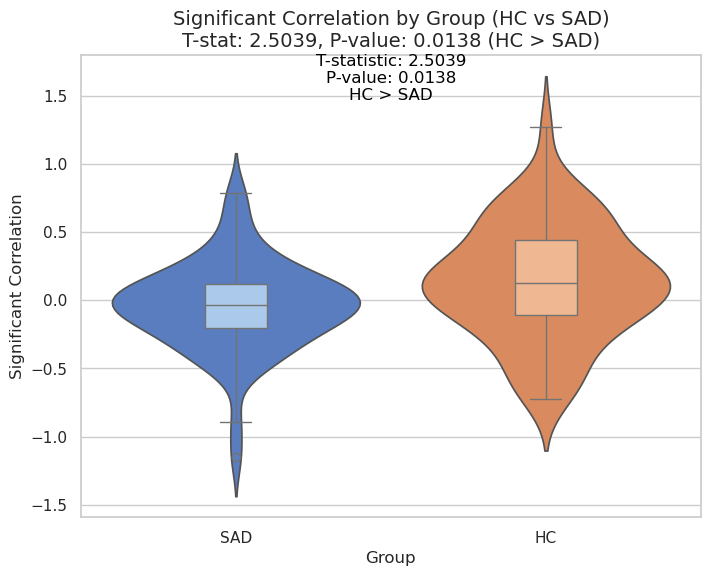

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


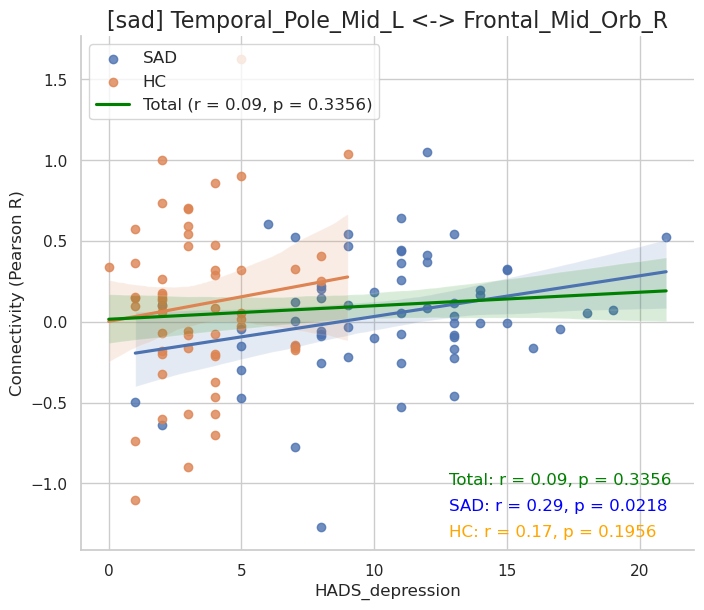

T-statistic: 0.8547, P-value: 0.3947


/tmp/ipykernel_860122/469149513.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Significant Correlation', data=merged_df, inner=None, palette="muted")
/tmp/ipykernel_860122/469149513.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Significant Correlation', data=merged_df, whis=2.5, width=0.2, palette="pastel")


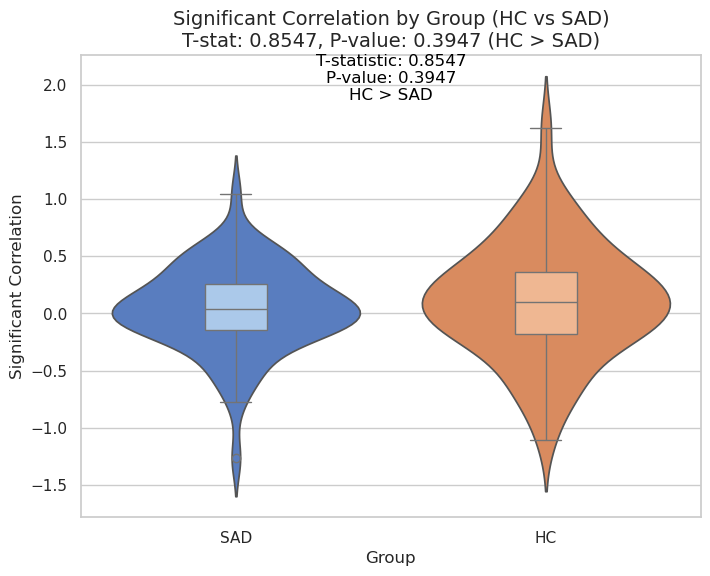

In [144]:
source_cluster = "Temporal_Pole_Mid_L"
variable_of_interest = "HADS_depression"
draw_reg(source_cluster, variable_of_interest)